In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import re
from tqdm import tqdm

import numpy as np
from scipy import interpolate, stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

In [2]:
from aatw.units_constants import *
from aatw.geometry import Glbd, GCstz, GCxyz_stz
from aatw.map_utils import plot_hv
from aatw.stats import sample_from_pdf, poisson_process
from aatw.nfw import rho_NFW
from aatw.snr import SNR, load_snr_list, dump_snr_list

In [3]:
valid_snr_list = load_snr_list("../data/SNR/snrlist_none.json")

## 1. rate

In [4]:
def snr_forming_rate_CC():
    """CC SNR formation rate [1/yr].
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    3.2+7.3-2.6 / 100 yr
    """
    return 3.2 / 100

def snr_forming_rate_Ia():
    """Ia SNR formation rate [1/yr].
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    1.4+1.4-0.8 / 100 yr
    """
    return 1.4 / 100

def snr_forming_rate_tot():
    """Total SNR formation rate [1/yr].
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    4.6+7.4-2.7 / 100 yr
    """
    return 4.6 / 100
    #return np.random.uniform(4.6+7.4, 4.6-2.7)

In [5]:
t_cutoff = 100000 # [yr] | end of adiabatic
n_snr_expected_tot = int(t_cutoff * snr_forming_rate_tot()) # [1]
print(n_snr_expected_tot)

4600


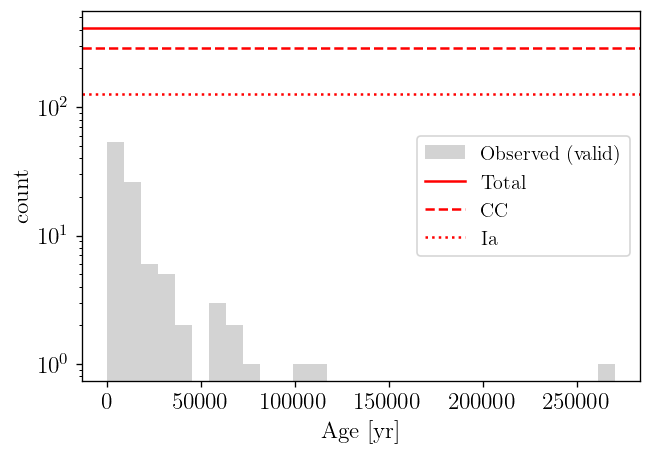

In [6]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist([snr.t_now for snr in valid_snr_list], bins=30, color='lightgray', label='Observed (valid)')
ax.axhline(y=snr_forming_rate_tot() * np.diff(bins)[0], color='r', label='Total')
ax.axhline(y=snr_forming_rate_CC() * np.diff(bins)[0], ls='--', color='r', label='CC')
ax.axhline(y=snr_forming_rate_Ia() * np.diff(bins)[0], ls=':', color='r', label='Ia')
ax.set(yscale='log')
ax.set(xlabel='Age [yr]', ylabel='count')
ax.legend();

## 2. location distribution

In [6]:
def snr_stz_pdf_AKBVS(stz):
    """CC SNR location pdf.
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    Vectorized in first dimension.
    """
    s, t, z = stz[:,0], stz[:,1], stz[:,2]
    s0 = 2.9 # [kpc]
    z0 = 0.095 # [kpc]
    return np.exp(-s/s0) * np.exp(-np.abs(z)/z0)

def sample_snr_stz_AKBVS(num_samples):
    """SNR location sampler.
    Following 1306.0559 Adams Kochanek Beacom Vagins Stanek.
    """
    s0 = 2.9 # [kpc]
    s_pdf = lambda s: np.exp(-s/s0)
    s_start, s_end = 0, 15 # [kpc]
    
    z0 = 0.095 # [kpc]
    z_pdf = lambda z: np.exp(-np.abs(z)/z0)
    z_start, z_end = -1, 1 # [kpc]
    
    s_samples = sample_from_pdf(s_pdf, s_start, s_end, num_samples)
    z_samples = sample_from_pdf(z_pdf, z_start, z_end, num_samples)
    t_samples = np.random.uniform(0, 2*np.pi, num_samples)
    
    return np.stack([s_samples,
                     t_samples,
                     z_samples], axis=-1)

In [7]:
def snr_stz_pdf_G(stz):
    """SNR location pdf.
    Following 1508.02931 Green.
    Vectorized in first dimension.
    
    Take z to be Uniform(-0.1, 0.1).
    SNR type: no mention
    """
    s, t, z = stz[:,0], stz[:,1], stz[:,2]
    
    R_sun = 8.5 # [kpc]
    alpha = 1.09 # [1]
    beta = 3.87 # [1]
    return (s/R_sun)**alpha * np.exp(-beta*(s-R_sun)/R_sun) * (np.abs(z) < 0.1)

def sample_snr_stz_G(num_samples):
    """SNR location sampler.
    Following 1508.02931 Green.
    Take z to be Uniform(-0.1, 0.1).
    """
    R_sun = 8.5 # [kpc]
    alpha = 1.09 # [1]
    beta = 3.87 # [1]
    s_pdf = lambda s: (s/R_sun)**alpha * np.exp(-beta*(s-R_sun)/R_sun)
    s_start, s_end = 0, 15 # [kpc]
    
    s_samples = sample_from_pdf(s_pdf, s_start, s_end, num_samples)
    z_samples = np.random.uniform(-0.1, 0.1, num_samples)
    t_samples = np.random.uniform(0, 2*np.pi, num_samples)
    
    return np.stack([s_samples,
                     t_samples,
                     z_samples], axis=-1)

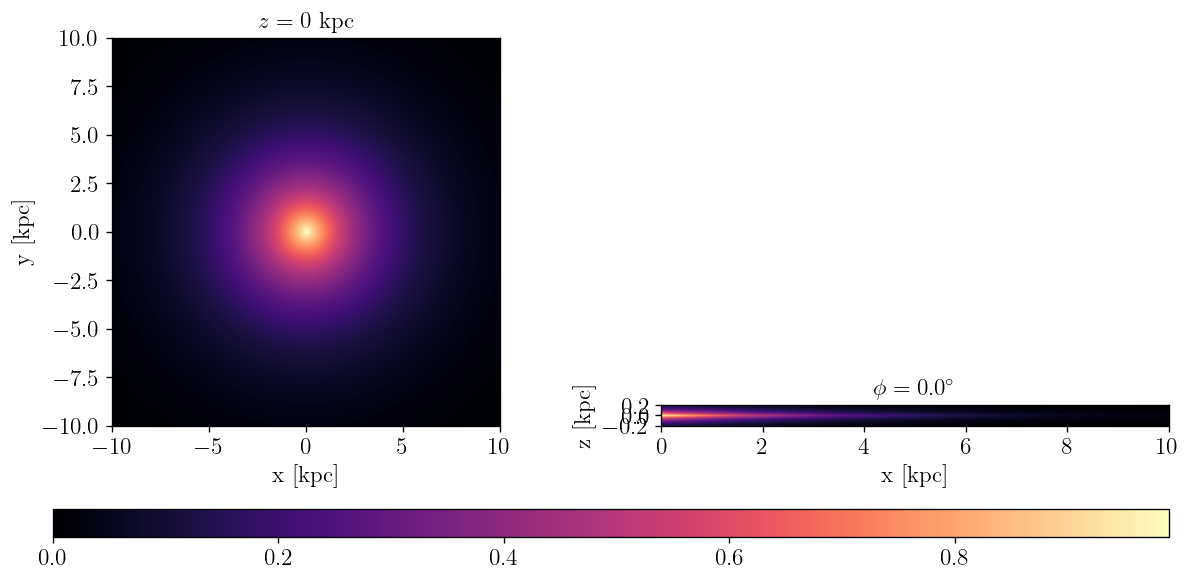

In [9]:
plot_hv(snr_stz_pdf_AKBVS, smax=10, zmax=0.2, npix=200)

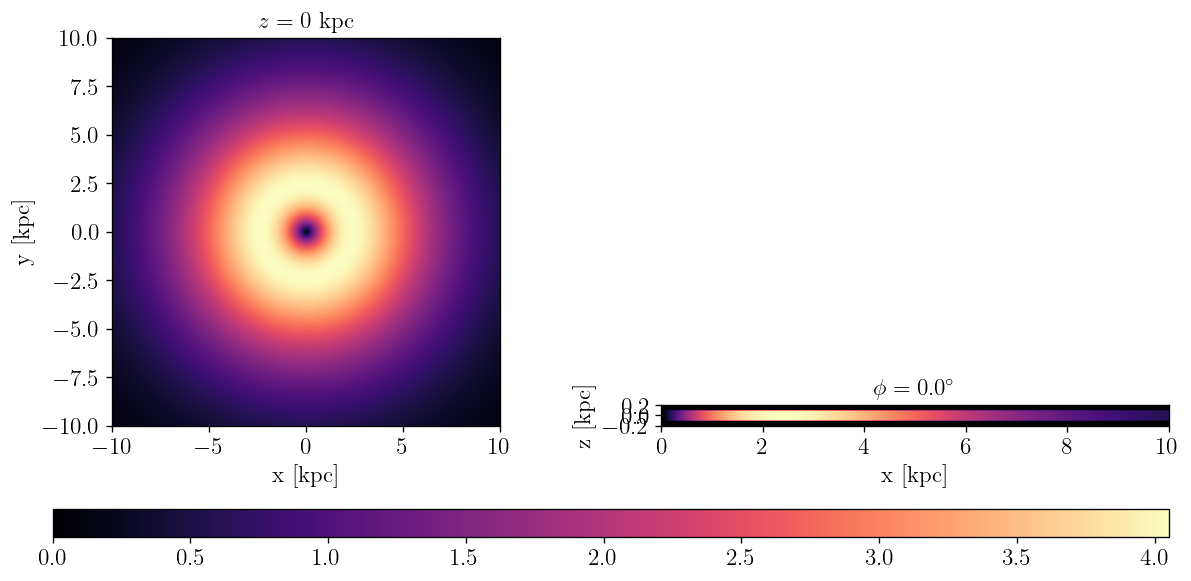

In [10]:
plot_hv(snr_stz_pdf_G, smax=10, zmax=0.2, npix=200)

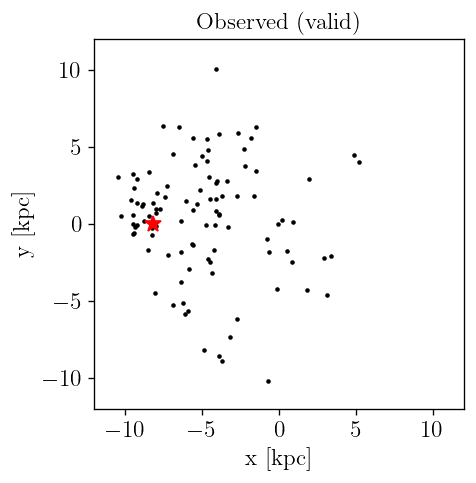

In [12]:
lbd = np.array([[snr.l, snr.b, snr.d] for snr in valid_snr_list])
xyz = GCxyz_stz(GCstz(lbd))

fig, ax = plt.subplots()
ax.scatter(xyz[:, 0], xyz[:, 1], s=3, c='k')
ax.plot([-r_Sun], [0], c='r', marker='*', ms=10)
ax.set(xlim=(-12, 12), ylim=(-12, 12), aspect=1)
ax.set(xlabel='x [kpc]', ylabel='y [kpc]', title='Observed (valid)');

In [9]:
lbd_pops = {}

lbd = np.array([[snr.l, snr.b, snr.d] for snr in valid_snr_list])
lbd[:, 0] = np.where(lbd[:, 0] > np.pi, lbd[:, 0]-2*np.pi, lbd[:, 0])
lbd_pops['obs'] = lbd

lbd_pops['AKBVS'] = Glbd(sample_snr_stz_AKBVS(n_snr_expected_tot))
lbd_pops['G'] = Glbd(sample_snr_stz_G(n_snr_expected_tot))

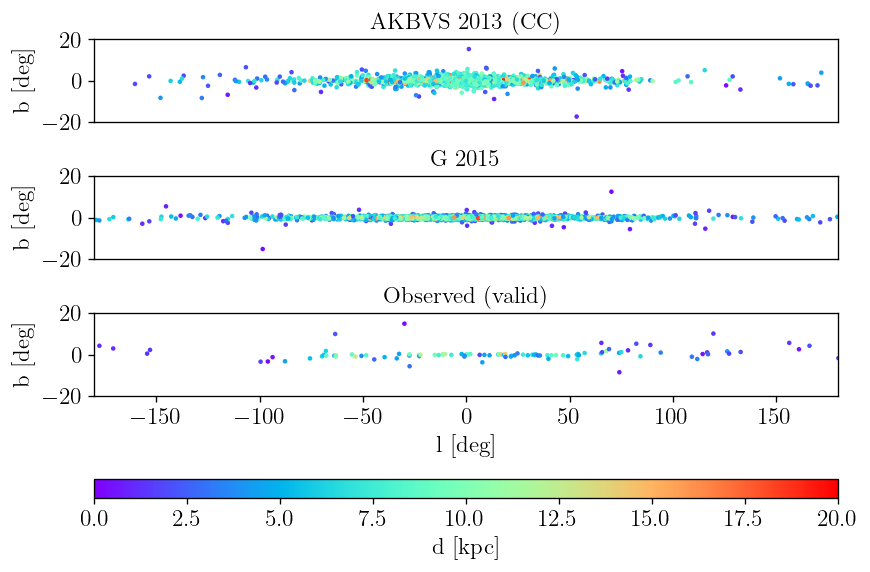

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

norm = mpl.colors.Normalize(vmin=0, vmax=20)

for i, k in enumerate(['AKBVS', 'G', 'obs']):
    lbd = lbd_pops[k]
    im = axs[i].scatter(
        np.rad2deg(lbd[:, 0]),
        np.rad2deg(lbd[:, 1]),
        c=lbd[:, 2], s=3,
        cmap='rainbow', norm=norm
    )
    axs[i].set(xlim=(-180, 180), ylim=(-20, 20), aspect=1)
    
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', aspect=40)
cbar.set_label('d [kpc]')

axs[0].set(ylabel='b [deg]', title='AKBVS 2013 (CC)', xticks=[])
axs[1].set(ylabel='b [deg]', title='G 2015', xticks=[])
axs[2].set(ylabel='b [deg]', title='Observed (valid)', xlabel='l [deg]');

## Remark
If we want to exclude the SNR's already found, we need to carve out a correlated portion in the age-location-luminosity distribution. Namely, we with bias observe young, bright, close-by SNRs.

We might also need to worry about SNR overlapping and foregrounds. With 360 deg / 4600 < 0.1 deg, and pixel size 0.25 deg, we expect many SNR's to be falling in the same $l$ bin. However, not all SNR's are that bright.

There won't be backgrounds: the bright parts are long gone.

## 3. spectral index from Green's catalog

In [8]:
si_arr = []

with open('../data/SNR/Green.txt') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[4:]):
        line = line.split('\n')[0].lstrip()
        line = re.sub(' +', ' ', line)
        si_str = line.split(' ')[10]
        
        si_str = si_str.replace('?', '')
        si_str = si_str.replace('varies', '')
        if si_str != '':
            si_arr.append(float(si_str))
            
si_arr = np.array(si_arr)

In [9]:
# fit
si_skewness, si_loc, si_scale = stats.skewnorm.fit(si_arr)
si_sampler = lambda size: stats.skewnorm.rvs(si_skewness, loc=si_loc, scale=si_scale, size=size)

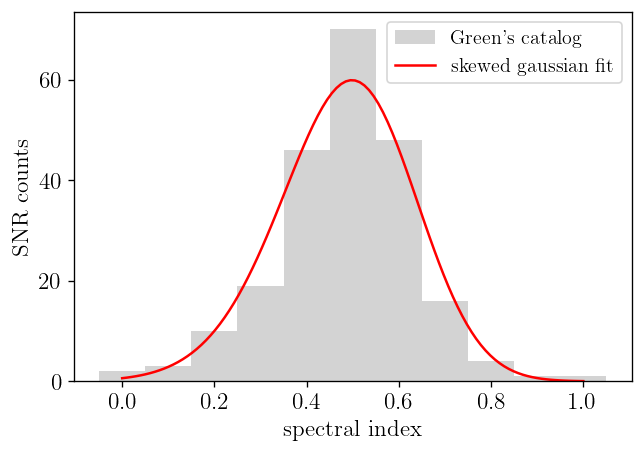

In [10]:
fig, ax = plt.subplots()

si_bins = np.linspace(-0.05, 1.05, 12)
si_counts, _, _ = ax.hist(si_arr, bins=si_bins, color='lightgray', label='Green\'s catalog')

plot_x = np.linspace(0, 1, 100)
plot_y = stats.skewnorm.pdf(plot_x, si_skewness, loc=si_loc, scale=si_scale)
ax.plot(plot_x, plot_y * len(si_arr) * np.diff(si_bins)[0], color='red', label='skewed gaussian fit')
ax.set(xlabel='spectral index', ylabel='SNR counts')
ax.legend();

## 4. size (at fixed age) from SNRcat

In [11]:
snr_size_1000yr_arr = [snr.size_t(1000) * snr.d for snr in valid_snr_list] # [kpc]

In [12]:
# fit
size_skewness, size_loc, size_scale = stats.skewnorm.fit(snr_size_1000yr_arr)
size_sampler = lambda size: stats.skewnorm.rvs(size_skewness, loc=size_loc, scale=size_scale, size=size)

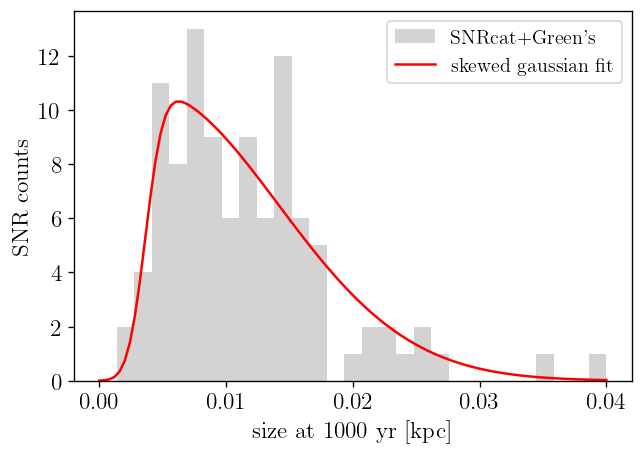

In [13]:
fig, ax = plt.subplots()

data = snr_size_1000yr_arr

bins = np.linspace(0, 0.04, 30)
counts, _, _ = ax.hist(data, bins=bins, color='lightgray', label='SNRcat+Green\'s')

plot_x = np.linspace(0, 0.04, 100)
plot_y = stats.skewnorm.pdf(plot_x, size_skewness, loc=size_loc, scale=size_scale)
ax.plot(plot_x, plot_y * len(data) * np.diff(bins)[0], color='red', label='skewed gaussian fit')
ax.set(xlabel='size at 1000 yr [kpc]', ylabel='SNR counts')
ax.legend();

## 5. $L_\mathrm{pk}$, $t_\mathrm{pk}$, and brightness history

In [14]:
t_pk_mean = 50 # [day]
t_pk_stddex = 0.9 # [1]
t_pk_sampler = lambda size: 10**(stats.norm.rvs(loc=np.log10(t_pk_mean), scale=t_pk_stddex, size=size)) / 365.25 # [yr]

In [15]:
L_pk_mean = 3e25 # [erg/s/Hz]
L_pk_stddex = 1.5 # [1]

L_pk_sampler = lambda size: 10**(stats.norm.rvs(loc=np.log10(L_pk_mean), scale=L_pk_stddex, size=size))

## 6. $t_\mathrm{free}$ from observed

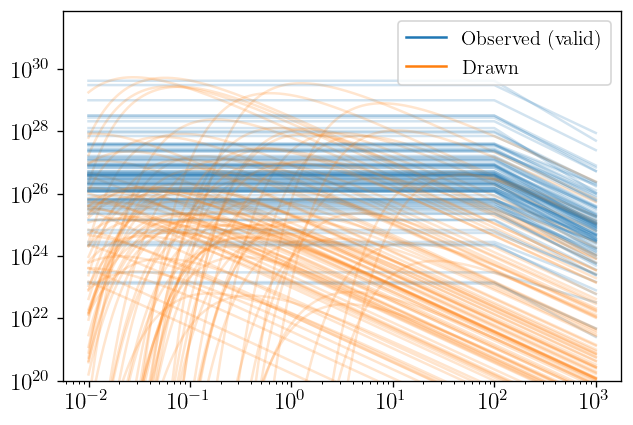

In [16]:
ts = np.geomspace(0.01, 1000, 1000)
fig, ax = plt.subplots()
for snr in valid_snr_list:
    factor = (4*np.pi*(snr.d*kpc)**2) * Jy * sec**2
    Lnu1GHz = snr.Snu1GHz * factor # [erg/s/Hz]
    Lnu1GHz_adiabatic = lambda t: Lnu1GHz * (t/snr.t_now)**snr.ti2
    L_pk = 10**(stats.norm.rvs(loc=np.log10(L_pk_mean), scale=L_pk_stddex))
    t_pk = 10**(stats.norm.rvs(loc=np.log10(t_pk_mean), scale=t_pk_stddex))
    Lnu1GHz_pk = L_pk * np.sqrt(4*10) ** (snr.si)
    Lnu1GHz_free = lambda t: Lnu1GHz_pk * jnp.exp(1.5*(1-t_pk/(t*365.25))) * ((t*365.25)/t_pk)**(-1.5)
    ax.plot(ts, [snr.Snu_t_fl(1000, t)*factor for t in ts], color='C0', alpha=0.2)
    ax.plot(ts, Lnu1GHz_free(ts), color='C1', alpha=0.2)
ax.loglog()
ax.set(ylim=(1e20, None))
ax.legend(
    [mpl.lines.Line2D([0], [0], color=c) for c in ['C0', 'C1']],
    ['Observed (valid)', 'Drawn'],
    loc='upper right'
);

In [17]:
ts = np.geomspace(0.001, 10000, 1000)

t_free_arr = []

for snr in tqdm(valid_snr_list):
    factor = (4*np.pi*(snr.d*kpc)**2) * Jy * sec**2
    Lnu1GHz = snr.Snu1GHz * factor # [erg/s/Hz]
    Lnu1GHz_adiabatic = Lnu1GHz * (ts/snr.t_now)**snr.ti2
    
    for _ in range(100):
        L_pk = 10**(stats.norm.rvs(loc=np.log10(L_pk_mean), scale=L_pk_stddex))
        t_pk = 10**(stats.norm.rvs(loc=np.log10(t_pk_mean), scale=t_pk_stddex))
        Lnu1GHz_pk = L_pk * np.sqrt(4*10) ** (snr.si)
        Lnu1GHz_free = Lnu1GHz_pk * jnp.exp(1.5*(1-t_pk/ts)) * (ts/t_pk)**(-1.5)
        
        if Lnu1GHz_free[-1] > Lnu1GHz_adiabatic[-1]:
            b = list(Lnu1GHz_free > Lnu1GHz_adiabatic)
            try:
                i = len(b) - 1 - b[::-1].index(False)
            except ValueError:
                i = -1
            if i > 0:
                t_free_arr.append(ts[i])

100%|█████████████████████████████████████████████████████████████████████████████████| 102/102 [00:30<00:00,  3.35it/s]


In [18]:
# fit
print(np.mean(t_free_arr), np.median(t_free_arr))
t_free_skewness, t_free_loc, t_free_scale = stats.skewnorm.fit(np.log10(t_free_arr))
t_free_sampler = lambda size: 10**stats.skewnorm.rvs(t_free_skewness, loc=t_free_loc, scale=t_free_scale, size=size)

478.6970263752532 102.3316578330245


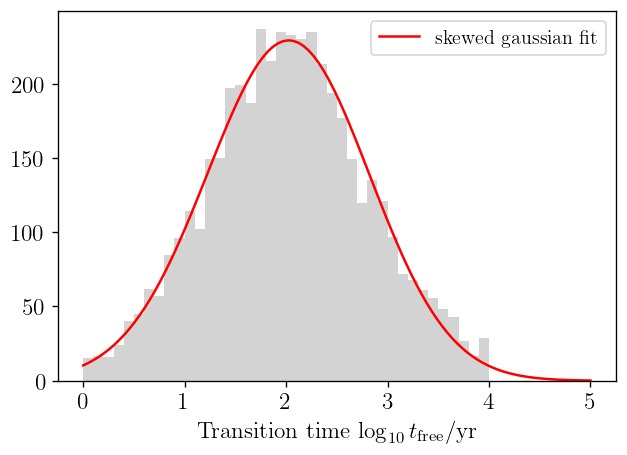

In [21]:
fig, ax = plt.subplots()

bins = np.linspace(0, 5, 50+1)
counts, _, _ = ax.hist(np.log10(t_free_arr), bins=bins, color='lightgray')

plot_x = np.linspace(0, 5, 100)
plot_y = stats.skewnorm.pdf(plot_x, t_free_skewness, loc=t_free_loc, scale=t_free_scale)
ax.plot(plot_x, plot_y * len(t_free_arr) * np.diff(bins)[0], color='red', label='skewed gaussian fit')
ax.set(xlabel=r'Transition time $\log_{10}t_\mathrm{free}/\mathrm{yr}$')
ax.legend();

Conclusion: Use 300 yr, and show systematics for 100 and 1000 yr.

## 7. Visible treshold

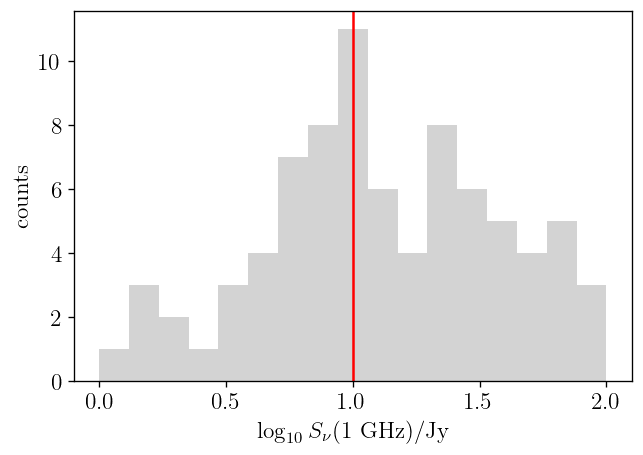

In [23]:
Snu1GHz_cutoff = 10 # [Jy]

plt.hist([np.log10(snr.Snu1GHz) for snr in valid_snr_list], bins=17, range=(0, 2), color='lightgray')
plt.axvline(np.log10(Snu1GHz_cutoff), color='r')
plt.xlabel(r'$\log_{10} S_\nu(1~\mathrm{GHz})/\mathrm{Jy}$')
plt.ylabel('counts');

Conclusion: Assume a cutoff and compare with observed spatial distribution below. Also do systematic checks.

## 8. Sample SNRs

In [24]:
def generate_graveyard_snrs(t_cutoff=100000, verbose=1):
    """t_cutoff in [yr], set at end of adiabatic phase typically.
    remove_Snu1GHz_above in [Jz]."""

    t_now_arr = np.array(poisson_process(snr_forming_rate_tot(), t_cutoff))
    n_snr = len(t_now_arr)
    if verbose >= 1:
        print(f'n_snr={n_snr}')
    
    lbd_arr = np.array(Glbd(sample_snr_stz_G(n_snr)), dtype=np.float64)
    si_arr = si_sampler(n_snr)
    size_arr = size_sampler(n_snr) * (1000/t_now_arr)**0.4
    L_pk_arr = L_pk_sampler(n_snr)
    t_pk_arr = t_pk_sampler(n_snr)
    #t_free_arr = t_free_sampler(n_snr)
    t_free_arr = np.full((n_snr,), 300.)
    
    snr_list = []
    
    for i in (tqdm(range(n_snr)) if verbose >= 1 else range(n_snr)):
    
        Snu6p3GHz_pk = L_pk_arr[i] / (4*np.pi*(lbd_arr[i, 2]*kpc)**2) / sec**2 / Jy # [Jy]
        si = si_arr[i]
        Snu1GHz_pk = Snu6p3GHz_pk * np.sqrt(4*10) ** (si)
        
        snr = SNR(
            ID = f'Graveyard-{i}',
            l = lbd_arr[i, 0],
            b = lbd_arr[i, 1],
            d = lbd_arr[i, 2],
            size = size_arr[i],
            t_now = t_now_arr[i],
            t_free = t_free_arr[i],
            t_pk = t_pk_arr[i],
            Snu1GHz_pk = Snu1GHz_pk,
            si = si,
        )
        snr.build(rho_DM=rho_NFW, use_lightcurve=True, integrate_method='trapz')
        snr_list.append(snr)
    return snr_list

In [25]:
snr_list = generate_graveyard_snrs(t_cutoff=100000)

n_snr=4635


100%|██████████████████████████████████████████████████████████████████████████████| 4635/4635 [00:17<00:00, 259.93it/s]


### 8.1 Check integrator convergence

In [26]:
%%time
for snr in tqdm(snr_list[:100]):
    snr.build(rho_DM=rho_NFW, use_lightcurve=True, integrate_method='quad')

 38%|███████████████████████████████▏                                                  | 38/100 [00:01<00:02, 26.30it/s]/Users/sunyitian/Dropbox (MIT)/Documents/P/all_sky_gegenschein/axions-against-the-world/notebooks/../aatw/snr.py:201: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(*args)[0]
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.41it/s]

CPU times: user 4.1 s, sys: 146 ms, total: 4.25 s
Wall time: 4.1 s


In [ ]:
for snr in snr_list[:10]:
    print(f'{snr.Sgnu_ref:.5e}, {snr.image_sigma:.5e}, {snr.Sfgnu_ref:.5e}, {snr.image_sigma_fg:.5e}')

In [28]:
%%time
for snr in tqdm(snr_list[:100]):
    snr.build(rho_DM=rho_NFW, use_lightcurve=True, integrate_method='trapz')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 251.88it/s]

CPU times: user 398 ms, sys: 3.12 ms, total: 401 ms
Wall time: 399 ms


In [ ]:
for snr in snr_list[:10]:
    print(f'{snr.Sgnu_ref:.5e}, {snr.image_sigma:.5e}, {snr.Sfgnu_ref:.5e}, {snr.image_sigma_fg:.5e}')

### 8.2 Rough estimates of the graveyard population

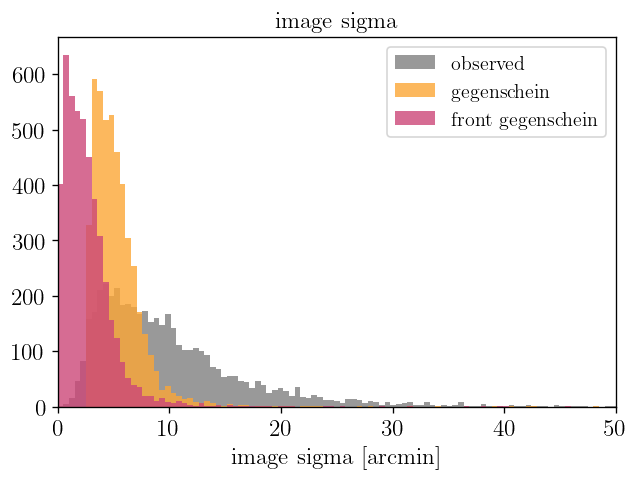

In [30]:
fig, ax = plt.subplots()

bins = np.linspace(0, 50, 100)

ax.hist([np.rad2deg(snr.size)*60 for snr in snr_list], bins=bins, label='observed', color='gray', alpha=0.8)
ax.hist([np.rad2deg(snr.image_sigma)*60 for snr in snr_list], bins=bins, label='gegenschein', color=cms['plasma'](0.8), alpha=0.8)
ax.hist([np.rad2deg(snr.image_sigma_fg)*60 for snr in snr_list], bins=bins, label='front gegenschein', color=cms['plasma'](0.5), alpha=0.8)
ax.set(xlim=(0, 50))
ax.set(title='image sigma', xlabel='image sigma [arcmin]')
ax.legend()

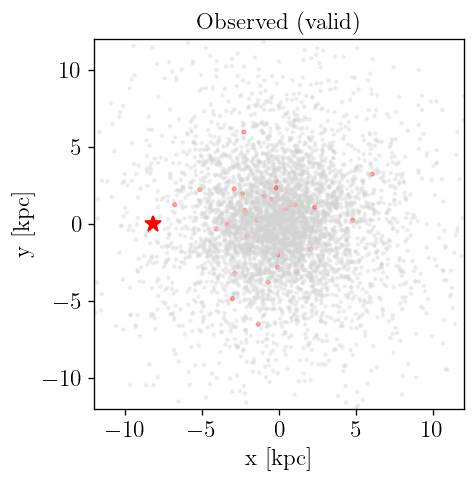

In [31]:
lbd = np.array([[snr.l, snr.b, snr.d] for snr in snr_list])
xyz = GCxyz_stz(GCstz(lbd))

c = [('r' if np.log10(snr.Snu1GHz) > 1 else 'lightgray') for snr in snr_list]
s = [(5 if np.log10(snr.Snu1GHz) > 1 else 3) for snr in snr_list]

fig, ax = plt.subplots()
ax.scatter(xyz[:, 0], xyz[:, 1], s=s, c=c, alpha=0.3)
ax.plot([-r_Sun], [0], c='r', marker='*', ms=10)
ax.set(xlim=(-12, 12), ylim=(-12, 12), aspect=1)
ax.set(xlabel='x [kpc]', ylabel='y [kpc]', title='Observed (valid)');

In [32]:
np.sum([np.log10(snr.Snu1GHz)>1 for snr in snr_list])

32

In [33]:
np.sum([np.log10(snr.Snu1GHz)>1 for snr in valid_snr_list])

61

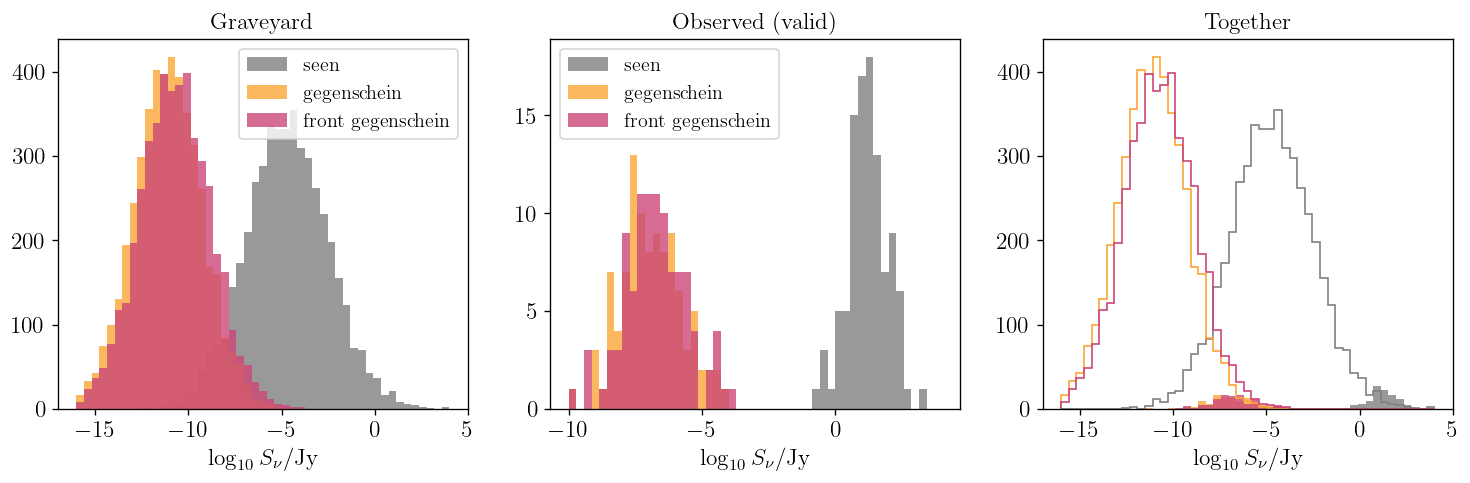

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

nu_ref = 1000

bins = np.linspace(-16, 4, 50)
axs[0].hist([np.log10(snr.Snu(nu_ref)) for snr in snr_list], bins=bins, label='seen', color='gray', alpha=0.8)
axs[0].hist([np.log10(snr.Sgnu(nu_ref)) for snr in snr_list], bins=bins, label='gegenschein', color=cms['plasma'](0.8), alpha=0.8)
axs[0].hist([np.log10(snr.Sfgnu(nu_ref)) for snr in snr_list], bins=bins, label='front gegenschein', color=cms['plasma'](0.5), alpha=0.8)
axs[0].set(title='Graveyard', xlabel=r'$\log_{10}S_\nu/\mathrm{Jy}$')
axs[0].legend()

bins = np.linspace(-10, 4, 50)
axs[1].hist([np.log10(snr.Snu(nu_ref)) for snr in valid_snr_list], bins=bins, label='seen', color='gray', alpha=0.8)
axs[1].hist([np.log10(snr.Sgnu(nu_ref)) for snr in valid_snr_list], bins=bins, label='gegenschein', color=cms['plasma'](0.8), alpha=0.8)
axs[1].hist([np.log10(snr.Sfgnu(nu_ref)) for snr in valid_snr_list], bins=bins, label='front gegenschein', color=cms['plasma'](0.5), alpha=0.8)
axs[1].set(title='Observed (valid)', xlabel=r'$\log_{10}S_\nu/\mathrm{Jy}$')
axs[1].legend()

bins = np.linspace(-16, 4, 50)
axs[2].hist([np.log10(snr.Snu(nu_ref)) for snr in snr_list], bins=bins, label='seen', color='gray', histtype='step')
axs[2].hist([np.log10(snr.Sgnu(nu_ref)) for snr in snr_list], bins=bins, label='gegenschein', color=cms['plasma'](0.8), histtype='step')
axs[2].hist([np.log10(snr.Sfgnu(nu_ref)) for snr in snr_list], bins=bins, label='front gegenschein', color=cms['plasma'](0.5), histtype='step')
axs[2].hist([np.log10(snr.Snu(nu_ref)) for snr in valid_snr_list], bins=bins, label='seen', color='gray', alpha=0.8)
axs[2].hist([np.log10(snr.Sgnu(nu_ref)) for snr in valid_snr_list], bins=bins, label='gegenschein', color=cms['plasma'](0.8), alpha=0.8)
axs[2].hist([np.log10(snr.Sfgnu(nu_ref)) for snr in valid_snr_list], bins=bins, label='front gegenschein', color=cms['plasma'](0.5), alpha=0.8)
axs[2].set(title='Together', xlabel=r'$\log_{10}S_\nu/\mathrm{Jy}$');

### 8.3 Sample SNRs

In [37]:
30 / c0_kpc_yr

97847.03898552191

In [40]:
for i_r in tqdm(range(100)):
    snr_list = generate_graveyard_snrs(t_cutoff=2e5, verbose=0)
    dump_snr_list(snr_list, f"../data/SNR/graveyard_realizations/graveyard_tc2e5_{i_r}.json")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [1:00:46<00:00, 36.46s/it]


### 8.4 Age convergence test

In [41]:
sens_ratio_dict = {}

for k in ['remove bright', 'keep bright']:
    
    print(k, ':')
    sens_ratio_arr_over_realizations = []

    for i_r in tqdm(range(100)):

        snr_list = load_snr_list(f"../data/SNR/graveyard_realizations/graveyard_tc2e5_{i_r}.json")
        t_cutoff_arr = np.geomspace(1e4, 2e5, 20)
        sens_ratio_arr = []

        for t_cutoff in t_cutoff_arr:
            if k == 'keep bright':
                snr_sublist = snr_list
            else:
                snr_sublist = [snr for snr in snr_list if snr.Snu1GHz <= 10]

            new = np.sqrt(  np.sum(np.array([snr.Sgnu_ref for snr in snr_sublist if snr.t_now < t_cutoff]) ** 2) \
                          + np.sum(np.array([snr.Sfgnu_ref for snr in snr_sublist if snr.t_now < t_cutoff]) ** 2))
            base = np.sqrt(  np.sum(np.array([snr.Sgnu_ref for snr in valid_snr_list]) ** 2) \
                           + np.sum(np.array([snr.Sfgnu_ref for snr in valid_snr_list]) ** 2))
            sens_ratio_arr.append(new/base)
        sens_ratio_arr_over_realizations.append(np.array(sens_ratio_arr))
        
    sens_ratio_dict[k] = sens_ratio_arr_over_realizations

remove bright :


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


keep bright :


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]


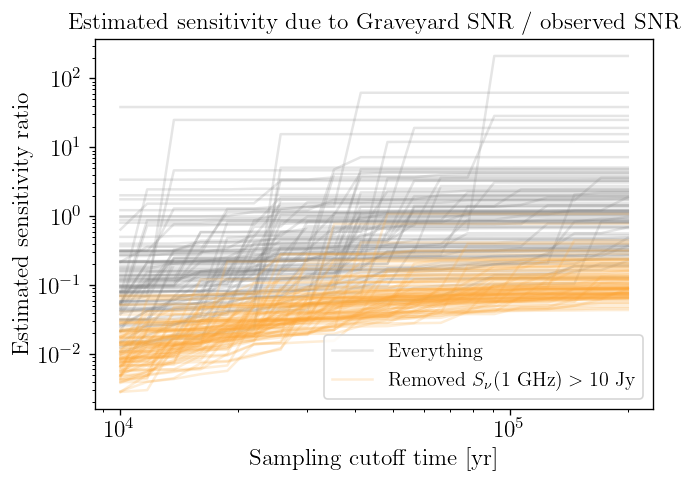

In [42]:
fig, ax = plt.subplots()
for i, sens_ratio_arr in enumerate(sens_ratio_dict['keep bright']):
    ax.plot(t_cutoff_arr, sens_ratio_arr, color='gray', alpha=0.2, label=('Everything' if i==0 else None))
for i, sens_ratio_arr in enumerate(sens_ratio_dict['remove bright']):
    ax.plot(t_cutoff_arr, sens_ratio_arr, color=cms['plasma'](0.8), alpha=0.2, label=(r'Removed $S_\nu(1~\mathrm{GHz})>10~$Jy' if i==0 else None))
ax.set(xscale='log', yscale='log')
ax.set(title='Estimated sensitivity due to Graveyard SNR / observed SNR',
       ylabel='Estimated sensitivity ratio', xlabel='Sampling cutoff time [yr]')
ax.legend();